# Cookbook: Classification of Food

In this cookbook, we will delve into classification, specifically focusing on how to leverage the Classifier Factory to create classifiers tailored to your needs and use cases.

For simplicity, we will concentrate on a specific example that requires multitarget classification.

## Food Classification

The specific use case we will explore is food classification. We aim to classify different dishes and recipes into various categories and further classify them by the main language of the recipe.

We will focus on three values:
- The dish or food name
- The country it belongs to
- The multi-categories

This means we need to classify two main aspects: the country and the categories to which the food belongs.

We will also arbitrarily decide that there should be no food without any category; there should always be at least one.

## Dataset

For this purpose, we will use a [subset](https://huggingface.co/datasets/pandora-s/openfood-classification) of the [Open Food Facts product database](https://huggingface.co/datasets/openfoodfacts/product-database) as the data relevant to our use case.

This subset was curated to focus on the most prevalent labels and underwent a few steps for balancing.

### Labels
There are 2 main labels:
- Country *single target*: The corresponding country of the food/dish among 8 possible values: `italy`, `spain`, `germany`, `france`, `united-states`, `belgium`, `united-kingdom` and `switzerland`.
- Category *multi-target*: The category it belongs to among 8 possible values: `snacks`, `beverages`, `cereals-and-potatoes`, `plant-based-foods`, `dairies`, `plant-based-foods-and-beverages`, `meats-and-their-products` and `sweet-snacks`.

There are 8 countries and 8 different categories.
Due to the nature of each label, the dataset is split as follows:
- `name`: The name of the food/dish, extracted from the `product_name` of the openfoodfacts/product-database dataset.
- `country_label`: The country ID, extracted from `countries_tags` of the openfoodfacts/product-database dataset.
- `category_labels`: The categories it belongs to, extracted from `categories_tags` of the openfoodfacts/product-database dataset.

### Distribution
![image/png](https://cdn-uploads.huggingface.co/production/uploads/64161701107962562e9b1006/UjF0RWnrYMTkN3SQZCjMl.png)
Note that the food categories overlap each other, since a sample can have multiple categories.

### Splits
The dataset was split into 3 sets:
- `train`: 80%
- `validation`: 10%
- `test`: 10%

### Data Preparation
Lets download the dataset, we will install `datasets` and load it.

In [1]:
%%capture
!pip install datasets

In [2]:
%%capture
from datasets import load_dataset

dataset = load_dataset('pandora-s/openfood-classification')
dataset

We can take a look at the test set directly by converting it to a pandas dataframe.

In [3]:
df = dataset["test"].to_pandas()
df

,name,country_label,category_labels
0,Avena e nocciole cioccolato fondente,italy,"{'plant-based-foods': 'false', 'cereals-and-po..."
1,Pomodori in pezzi,belgium,"{'plant-based-foods': 'false', 'cereals-and-po..."
2,"Grandyoats, Nori Sesame Cashews",united-states,"{'plant-based-foods': 'false', 'cereals-and-po..."
3,Jus d'orange Profit,switzerland,"{'plant-based-foods': 'false', 'cereals-and-po..."
4,Rote Beete,germany,"{'plant-based-foods': 'true', 'cereals-and-pot..."
...,...,...,...
10030,Yaourt doux,france,"{'plant-based-foods': 'false', 'cereals-and-po..."
10031,Mirtillo di bosco,italy,"{'plant-based-foods': 'false', 'cereals-and-po..."
10032,Rôti de porc cuit supérieur,france,"{'plant-based-foods': 'false', 'cereals-and-po..."
10033,Mix de vegetales con pepinillo,spain,"{'plant-based-foods': 'true', 'cereals-and-pot..."


Now that we have loaded our dataset, we will convert it to the proper desired format to upload for training.

The data will be converted to a jsonl format as follows:
```json
{"text": "Avena e nocciole cioccolato fondente", "labels": {"food": ["sweet-snacks"], "country_label": "italy"}}
{"text": "Pomodori in pezzi", "labels": {"food": ["plant-based-foods-and-beverages"], "country_label": "belgium"}}
{"text": "Grandyoats, Nori Sesame Cashews", "labels": {"food": ["snacks"], "country_label": "united-states"}}
{"text": "Jus d'orange Profit", "labels": {"food": ["beverages", "plant-based-foods-and-beverages"], "country_label": "switzerland"}}
{"text": "Rote Beete", "labels": {"food": ["plant-based-foods", "plant-based-foods-and-beverages"], "country_label": "germany"}}
...
```
With an example of a label being:
```json
"labels": {
  "food": [
    "beverages",
    "plant-based-foods-and-beverages"
  ],
  "country_label": "switzerland"
}
```
For multi-target classification.

In [4]:
from tqdm import tqdm
import json

def dataset_to_jsonl(split):
    jsonl_data = []

    all_category_labels = set()
    all_countries = set()

    # Collect all unique category labels and countries
    for example in dataset[split]:
        all_category_labels.update(example['category_labels'].keys())
        all_countries.add(example['country_label'])

    # Convert sets to sorted lists for consistent formatting
    all_category_labels = sorted(all_category_labels)
    all_countries = sorted(all_countries)

    # Process each example in the split
    for example in tqdm(dataset[split]):
        labels = {
            "food": [
                tag
                for tag in all_category_labels
                if example['category_labels'][tag] == "true"
            ]
        }
        labels["country_label"] = example['country_label']

        jsonl_data.append({
            "text": example['name'],
            "labels": labels
        })

    return jsonl_data, all_category_labels, all_countries

# Process each split
train_jsonl, _, _ = dataset_to_jsonl('train')
validation_jsonl, _, _ = dataset_to_jsonl('validation')
test_jsonl, all_category_labels, all_country_labels = dataset_to_jsonl('test')

# Save the formatted data as JSONL files
for split, data in zip(['train', 'validation', 'test'], [train_jsonl, validation_jsonl, test_jsonl]):
    with open(f'{split}_openfood_classification.jsonl', 'w') as f:
        for entry in data:
            f.write(json.dumps(entry) + '\n')

print("JSONL files have been saved.")


100%|██████████████████████████████████| 10035/10035 [00:00<00:00, 69111.90it/s]


JSONL files have been saved.


The data was converted and saved properly. We can now train our model.

## Training
There are two methods to train the model: either upload and train via [la platforme](https://console.mistral.ai/build/finetuned-models) or via the [API](https://classifier-factory.platform-docs-9m1.pages.dev/capabilities/finetuning/classifier_factory/).

First, we need to install `mistralai`.

In [5]:
!pip install mistralai


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from mistralai import Mistral
import os
from dotenv import load_dotenv

load_dotenv()

# Set the API key for Mistral
api_key = os.getenv("MISTRAL_API_KEY")

# Set your Weights and Biases key
wandb_key = "your_key"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

We will upload 2 files, the training set and the validation set ( optional ) that will be used for validation loss.

In [7]:
# Upload the training data
training_data = client.files.upload(
    file={
        "file_name": "train_openfood_classification.jsonl",
        "content": open("train_openfood_classification.jsonl", "rb"),
    }
)

# Upload the validation data
validation_data = client.files.upload(
    file={
        "file_name": "validation_openfood_classification.jsonl",
        "content": open("validation_openfood_classification.jsonl", "rb"),
    }
)

With the data uploaded, we can create a job.

We allow users to keep track of aconsiderable amount of metrics via our Weights and Biases integration that we strongly recommend, you can make use of it by providing the project name and your key.

In [8]:
# Create a fine-tuning job
created_job = client.fine_tuning.jobs.create(
    model="ministral-3b-latest",
    job_type="classifier",
    training_files=[{"file_id": training_data.id, "weight": 1}],
    validation_files=[validation_data.id],
    hyperparameters={"training_steps": 250, "learning_rate": 0.00007},
    auto_start=False,
    integrations=[
        {
            "project": "Product Classification",
            "api_key": wandb_key,
        }
    ]
)
print(json.dumps(created_job.model_dump(), indent=4))

{
    "id": "4d00ec0c-f142-476f-83d4-99356bae3943",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1750342387,
    "modified_at": 1750342387,
    "training_files": [
        "7e912ee2-3e82-40e8-b9c2-9da4270b2227"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": null,
        "seq_len": 16384
    },
    "validation_files": [
        "5410324a-8544-4252-a63a-37459b981a9a"
    ],
    "object": "job",
    "fine_tuned_model": null,
    "suffix": null,
    "integrations": [
        {
            "project": "Product Classification",
            "type": "wandb",
            "name": null,
            "run_name": null,
            "url": null
        }
    ],
    "trained_tokens": null,
    "metadata": {
        "expected_duration_seconds": null,
        "cost": 0.0,
        "cost_currency": null,
        "train_toke

Once the job is created, we can review details such as the number of epochs and other relevant information. This allows us to make informed decisions before initiating the job.

We'll retrieve the job and wait for it to complete the validation process before starting. This validation step ensures the job is ready to begin.

In [9]:
# Retrieve the job details
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

import time
from IPython.display import clear_output

# Wait for the job to be validated
while retrieved_job.status not in ["VALIDATED"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    clear_output(wait=True)  # Clear the previous output (User Friendly)
    print(json.dumps(retrieved_job.model_dump(), indent=4))
    time.sleep(1)

{
    "id": "4d00ec0c-f142-476f-83d4-99356bae3943",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "VALIDATED",
    "created_at": 1750342387,
    "modified_at": 1750342393,
    "training_files": [
        "7e912ee2-3e82-40e8-b9c2-9da4270b2227"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 5.511569451695722,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "food",
            "labels": [
                "snacks",
                "plant-based-foods",
                "beverages",
                "plant-based-foods-and-beverages",
                "meats-and-their-products",
                "sweet-snacks",
                "dairies",
                "cereals-and-potatoes"
            ],
            "weight": 1.0,
            "loss_function": "multi_class"
        },
        {
            "name": "

We can now run the job.

In [10]:
# Start the fine-tuning job
client.fine_tuning.jobs.start(job_id=created_job.id)

# Retrieve the job details again
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

{
    "id": "4d00ec0c-f142-476f-83d4-99356bae3943",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1750342387,
    "modified_at": 1750342397,
    "training_files": [
        "7e912ee2-3e82-40e8-b9c2-9da4270b2227"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 5.511569451695722,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "food",
            "labels": [
                "snacks",
                "plant-based-foods",
                "beverages",
                "plant-based-foods-and-beverages",
                "meats-and-their-products",
                "sweet-snacks",
                "dairies",
                "cereals-and-potatoes"
            ],
            "weight": 1.0,
            "loss_function": "multi_class"
        },
        {
            "name": "cou

The job is now starting. Let's keep track of the status and plot the loss.

For that, we highly recommend making use of our Weights and Biases integration, but we will also keep track of it directly in this notebook.

### WANDB

**Training:**

![product-train-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/product-train-loss.png)

**Eval/Validation:**

![product-validation-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/product-eval-loss.png)

**More:**

![product-panel-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/product-panel-loss.png)

![product-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/product-loss.png)

In [12]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 10.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.0 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


FAILED


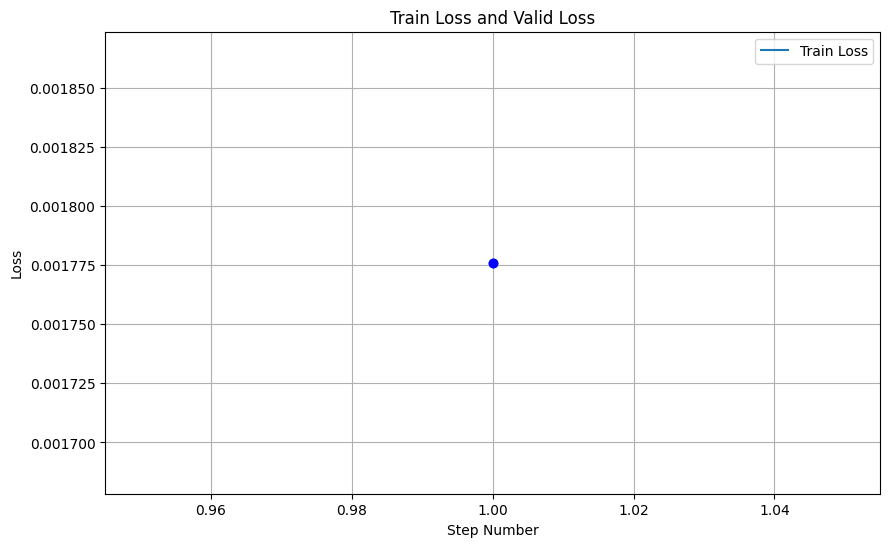

In [13]:
# @title Loss Plot
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initialize DataFrames to store the metrics
train_metrics_df = pd.DataFrame(columns=["Step Number", "Train Loss"])
valid_metrics_df = pd.DataFrame(columns=["Step Number", "Valid Loss"])

# Total training steps
total_training_steps = retrieved_job.hyperparameters.training_steps

# Wait for the job to complete
while retrieved_job.status in ["QUEUED", "RUNNING"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    if retrieved_job.status == "QUEUED":
        time.sleep(5)
        continue

    # Clear the previous output (User Friendly)
    clear_output(wait=True)
    print(retrieved_job.status)

    # Extract metrics from all checkpoints
    for checkpoint in retrieved_job.checkpoints[::-1]:
        metrics = checkpoint.metrics
        step_number = checkpoint.step_number

        # Check if the step number is already in the DataFrame
        if (
            step_number
            not in train_metrics_df["Step Number"]
        ):
            # Prepare the new row for train loss
            train_row = {
                "Step Number": step_number,
                "Train Loss": metrics.train_loss,
            }

            # Append the new train metrics to the DataFrame
            train_metrics_df = pd.concat(
                [train_metrics_df, pd.DataFrame([train_row])], ignore_index=True
            )

            # Prepare the new row for valid loss if available
            if metrics.valid_loss != 0:
                valid_row = {
                    "Step Number": step_number,
                    "Valid Loss": metrics.valid_loss,
                }
                # Append the new valid metrics to the DataFrame
                valid_metrics_df = pd.concat(
                    [valid_metrics_df, pd.DataFrame([valid_row])], ignore_index=True
                )

    if len(retrieved_job.checkpoints) > 0:
        # Sort the DataFrames by step number
        train_metrics_df = train_metrics_df.sort_values(by="Step Number")
        valid_metrics_df = valid_metrics_df.sort_values(by="Step Number")

        # Plot the evolution of train loss and valid loss
        plt.figure(figsize=(10, 6))

        # Plot train loss
        plt.plot(
            train_metrics_df["Step Number"],
            train_metrics_df["Train Loss"],
            label="Train Loss",
            linestyle="-",
        )

        # Highlight start and end points of train loss
        plt.scatter(
            train_metrics_df.iloc[[0, -1]]["Step Number"],
            train_metrics_df.iloc[[0, -1]]["Train Loss"],
            color="blue",
            zorder=5,
        )

        # Plot valid loss only if available
        if not valid_metrics_df.empty:
            plt.plot(
                valid_metrics_df["Step Number"],
                valid_metrics_df["Valid Loss"],
                label="Valid Loss",
                linestyle="--",
            )

            # Highlight start and end points of valid loss
            plt.scatter(
                valid_metrics_df.iloc[[0, -1]]["Step Number"],
                valid_metrics_df.iloc[[0, -1]]["Valid Loss"],
                color="orange",
                zorder=5,
            )

        plt.xlabel("Step Number")
        plt.ylabel("Loss")
        plt.title("Train Loss and Valid Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    time.sleep(1)

### Inference
Our model is trained and ready for use! Let's test it on a sample from our test set!

In [ ]:
# Load the test samples
with open("test_openfood_classification.jsonl", "r") as f:
    test_samples = [json.loads(l) for l in f.readlines()]

# Classify the first test sample
classifier_response = client.classifiers.classify(
    model=retrieved_job.fine_tuned_model,
    inputs=[test_samples[0]["text"]],
)
print("Text:", test_samples[0]["text"])
print("Classifier Response:", json.dumps(classifier_response.model_dump(), indent=4))

We can go even further and compare side by side normal prompting techniques with LLMs VS our new classifier, for this we will run the test set on multiple llms with structured outputs and compare the results to our classifier.

In [ ]:
# @title Load Test and Set Response Type
import json
from pydantic import BaseModel
from enum import Enum
from typing import List

# Load the JSONL file
file_path = 'test_openfood_classification.jsonl'
test_dataset = []

with open(file_path, 'r') as file:
    for line in file:
        test_dataset.append(json.loads(line))

# Define the enumerators for categories and countries
Category = Enum('Category', {category.replace('-', '_'): category for category in all_category_labels})
Country = Enum('Country', {country.replace('-', '_'): country for country in all_country_labels})

# Define the Food model using the enumerators
class Food(BaseModel):
    categories: List[Category]
    country: Country

In [ ]:
# @title Define the Classify Function
import random

instruction_prompt = """Classify the following food product, you need to classify the country of the dish and the food categories it belongs to.

Product Name: {}"""

def classify(text: str, model: str) -> tuple:
    try:
        if model["type"] == "random":
            possible_categories = list(all_category_labels)
            possible_countries = list(all_country_labels)
            predicted_categories = random.sample(possible_categories, random.randint(0, len(possible_categories)))
            predicted_country = random.choice(possible_countries)
            return predicted_categories, predicted_country
        elif model["type"] == "classifier":
            classifier_response = client.classifiers.classify(
                model=model["model_id"],
                inputs=[text],
            )
            results = classifier_response.results[0]

            # Extract all labels with their scores
            labels_with_scores = {label: results['food'].scores[label] for label in results['food'].scores.keys()}

            # Find the country with the highest score
            country_scores = results['country_label'].scores
            country_with_highest_score = max(country_scores, key=country_scores.get)

            return labels_with_scores, country_with_highest_score
        else:
            chat_response = client.chat.parse(
                model=model["model_id"],
                messages=[
                    {
                        "role": "user",
                        "content": instruction_prompt.format(text),
                    },
                ],
                response_format=Food,
                max_tokens=512,
                temperature=0
            )

            return [c.value for c in chat_response.choices[0].message.parsed.categories], chat_response.choices[0].message.parsed.country.value
    except Exception as e:
        return {}, None

In [ ]:
# @title Run Evaluation
from tqdm import tqdm
import numpy as np

# Number of samples to evaluate
n_samples = 300

def calculate_score(actual, predicted):
    """
    Calculate the accuracy score for a single label.

    Parameters:
    - actual: List of actual labels for each entry.
    - predicted: List of predicted labels for each entry.

    Returns:
    - The accuracy score as a float.
    """
    correct_predictions_count = 0
    total_predictions_count = 0

    for actual_labels, predicted_labels in zip(actual, predicted):
        if actual_labels or predicted_labels:
            total_predictions_count += 1
            if actual_labels and predicted_labels:
                correct_predictions_count += 1

    return correct_predictions_count / total_predictions_count if total_predictions_count > 0 else 0

def calculate_country_score(actual, predicted):
    """
    Calculate the accuracy score for country predictions.

    Parameters:
    - actual: List of actual country labels for each entry.
    - predicted: List of predicted country labels for each entry.

    Returns:
    - The accuracy score as a float.
    """
    correct_predictions_count = sum(actual_country == predicted_country for actual_country, predicted_country in zip(actual, predicted))
    total_predictions = len(actual)
    accuracy_score = correct_predictions_count / total_predictions if total_predictions > 0 else 0

    return accuracy_score

def evaluate_classifier(dataset, model):
    """
    Evaluate the classifier model on the dataset.

    Parameters:
    - dataset: List of entries with text and labels.
    - model: Dictionary containing model details.

    Returns:
    - Category scores, country score, average category score, and best threshold (if applicable).
    """

    # Initialize dictionaries to store actual and predicted labels for each category
    category_scores = {label: {"actual": [], "predicted": []} for label in all_category_labels}
    all_actual_countries = []
    all_predicted_countries = []

    # Store raw scores for classifier models
    raw_scores = []

    # Evaluate each entry in the dataset
    for entry in tqdm(dataset[:n_samples]):
        text = entry["text"]
        actual_categories = [cat for cat in entry["labels"]["food"]]
        actual_country = entry["labels"]["country_label"]

        # Predict categories and country using the model
        if model["type"] == "classifier":
            predicted_categories, predicted_country = classify(text, model)
            raw_scores.append((predicted_categories, predicted_country))
        else:
            predicted_categories, predicted_country = classify(text, model)

        # Accumulate actual and predicted categories and countries
        all_actual_countries.append(actual_country)
        all_predicted_countries.append(predicted_country)

        for label in all_category_labels:
            actual_label = [label] if label in actual_categories else []
            predicted_label = [label] if label in predicted_categories else []
            category_scores[label]["actual"].append(actual_label)
            category_scores[label]["predicted"].append(predicted_label)

    if model["type"] == "classifier":
        best_threshold = None
        best_average_category_score = 0

        # Find the best threshold for the classifier model
        for threshold in model["thresholds"]:
            actual_labels_per_category = {label: data["actual"] for label, data in category_scores.items()}
            predicted_labels_per_category = {label: [] for label in all_category_labels}

            for raw_score in raw_scores:
                predicted_categories, _ = raw_score
                predicted_labels = [label for label, score in predicted_categories.items() if score > threshold]
                for label in all_category_labels:
                    predicted_labels_per_category[label].append([label] if label in predicted_labels else [])

            category_score_results = {
                label: calculate_score(actual_labels_per_category[label], predicted_labels_per_category[label])
                for label in all_category_labels
            }
            average_category_score = np.mean(list(category_score_results.values()))

            if average_category_score > best_average_category_score:
                best_average_category_score = average_category_score
                best_threshold = threshold

        # Use the best threshold to compute final scores
        predicted_labels_per_category = {label: [] for label in all_category_labels}

        for raw_score in raw_scores:
            predicted_categories, _ = raw_score
            predicted_labels = [label for label, score in predicted_categories.items() if score > best_threshold]
            for label in all_category_labels:
                predicted_labels_per_category[label].append([label] if label in predicted_labels else [])

        category_score_results = {
            label: calculate_score(actual_labels_per_category[label], predicted_labels_per_category[label])
            for label in all_category_labels
        }
        country_score = calculate_country_score(all_actual_countries, all_predicted_countries)
        average_category_score = best_average_category_score
        return category_score_results, country_score, average_category_score, best_threshold
    else:
        # Prepare the actual and predicted labels for each category
        actual_labels_per_category = {label: data["actual"] for label, data in category_scores.items()}
        predicted_labels_per_category = {label: data["predicted"] for label, data in category_scores.items()}

        # Calculate score for each category and overall country score
        category_score_results = {
            label: calculate_score(actual_labels_per_category[label], predicted_labels_per_category[label])
            for label in all_category_labels
        }
        country_score = calculate_country_score(all_actual_countries, all_predicted_countries)

        # Calculate average category score
        average_category_score = np.mean(list(category_score_results.values()))

        return category_score_results, country_score, average_category_score, None

# Dictionary to store model evaluation results
model_results = {}

# List of models to evaluate
models = [
    {"type": "random", "model_name": "Random"},
    {
        "type": "classifier",
        "model_name": "Finetuned Classifier 3B",
        "model_id": retrieved_job.fine_tuned_model,
        "thresholds": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9] # the thresholds to try our multilabels on, depending on your data, training and use case, you may want to change your threshold to get the best score out of your model for your specific metric
    },
    {"type": "instruction", "model_name": "Ministral 3B", "model_id": "ministral-3b-latest"},
    {"type": "instruction", "model_name": "Ministral 8B", "model_id": "ministral-8b-latest"},
    {"type": "instruction", "model_name": "Mistral Small 24B", "model_id": "mistral-small-latest"},
    {"type": "instruction", "model_name": "Mistral Large 123B", "model_id": "mistral-large-latest"},
]

# Evaluate each model
for model in models:
    print("\nRunning", model, "...")
    category_scores, country_score, average_category_score, best_threshold = evaluate_classifier(test_dataset, model)

    result = {
        "category_scores": category_scores,
        "average_category_score": average_category_score,
        "country_score": country_score,
    }

    model_name = model['model_name']
    if model["type"] == "classifier":
        model_name = f"{model['model_name']} Threshold: {best_threshold}"

    model_results[model_name] = result

    print(f"Category Scores: {category_scores}")
    print(f"Average Category Score: {average_category_score}")
    print(f"Country Score: {country_score}")
    if model["type"] == "classifier":
        print(f"Best Threshold: {best_threshold}")


In [ ]:
# @title Plot Results
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_bar_chart(ax, data, labels, title, xlabel, ylabel, colors, bar_width, best_model=None):
    index = np.arange(len(labels))
    total_bars = len(labels) * len(data)

    group_spacing = 0.4
    group_width = bar_width * len(data)

    # Get the scores for the "random" model
    random_scores = data.get('Random', [0] * len(labels))

    # Get the scores for the best model
    best_model_scores = data.get(best_model, [0] * len(labels)) if best_model else [0] * len(labels)

    for i, (model, metrics) in enumerate(data.items()):
        positions = index + i * bar_width - group_width / 2 + group_spacing / 2
        color = 'red' if model == 'Random' else colors[i]
        bars = ax.bar(positions, metrics, width=bar_width, label=model, color=color, zorder=2)

        # Check if the model is the best model
        if model == best_model:
            for bar in bars:
                bar.set_hatch('//')
                bar.set_edgecolor('#FF8C00')
                height = bar.get_height()
                ax.annotate(f'{int(100 * height)}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5),
                            textcoords="offset points",
                            ha='center', va='bottom',
                            color='orange', fontsize=10)

        # Annotate the random model's bars
        if model == 'Random':
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{int(100 * height)}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5),  # 5 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            color='red', fontsize=10)

    # Add a red horizontal line for the "random" model's scores
    for idx, score in enumerate(random_scores):
        ax.hlines(y=score, xmin=index[idx] - group_width / 2 + bar_width,
                  xmax=index[idx] + group_width / 2 + bar_width, color='red', linestyle=':', linewidth=0.8, zorder=3)

    # Add a green horizontal line for the "best" model's scores
    for idx, score in enumerate(best_model_scores):
        ax.hlines(y=score, xmin=index[idx] - group_width / 2 + bar_width,
                  xmax=index[idx] + group_width / 2 + bar_width, color='orange', linestyle=':', linewidth=0.8, zorder=3)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(index + group_spacing / 2)
    ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=6)
    ax.set_ylim(0, 1.19)
    ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add a light grid in the background
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, zorder=1)

def plot_score_metrics(model_results, n_samples):
    # Find best model
    best_model = max(
        (model for model in model_results.keys()),
        key=lambda model: model_results[model]['average_category_score'],
        default=None
    )

    models = [m for m in model_results.keys()]
    colors = cm.YlOrBr(np.linspace(0.4, 0.6, len(models)))

    # Create a figure with a 2x1 grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 16))
    fig.suptitle(f'Scores (n_samples = {n_samples})')

    # Categories Score
    categories_score = {model: [model_results[model]['category_scores'][category] for category in model_results[model]['category_scores']] for model in models}
    plot_bar_chart(axes[0], categories_score, list(model_results[models[0]]['category_scores'].keys()),
                   'Category Scores', 'Category', 'Score', colors, 0.14, best_model)

    # Average Category Score and Countries Score as subplots in the second row
    average_category_score = {model: [model_results[model]['average_category_score']] for model in models}
    countries_score = {model: [model_results[model]['country_score']] for model in models}

    # Combine the two metrics into one subplot
    combined_metrics = {model: average_category_score[model] + countries_score[model] for model in models}
    plot_bar_chart(axes[1], combined_metrics, ['Average Category Scores', 'Country Scores'],
                   'Average Category and Country Scores', 'Metric', 'Score', colors, 0.14, best_model)

    plt.show()

plot_score_metrics(model_results, n_samples)

For this specific use case, most llms are struggling, this can be due to various reasons, bad prompting, small models, too specific use case...

However, our finetuned classifier performs extremely well, outperforming all other models by a decent margin! Making it not only better, but also more efficient and cheaper, as a considerably smaller model compared to its older brothers.